In [ ]:
# script to test out changes in the uncertainty tool's sensitivity function

In [36]:
import os
import rmgpy.tools.uncertainty
import rmgpy.chemkin

import matplotlib.pyplot as plt
%matplotlib inline

import importlib
importlib.reload(rmgpy.tools.uncertainty)


import rmgpy.rmg.settings

In [37]:
uncertainty = rmgpy.tools.uncertainty.Uncertainty(output_directory='test_sens_ct')

sevy_mech = '/home/moon/rmg/RMG-Py/examples/rmg/superminimal/chemkin'
s_chemkin = os.path.join(sevy_mech, 'chem_annotated.inp')
s_dict = os.path.join(sevy_mech, 'species_dictionary.txt')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(s_chemkin, s_dict)

uncertainty.species_list = species_list
uncertainty.reaction_list = reaction_list


In [38]:
T = 1500.0
P = 100000.0
# initial_mole_fractions='H2(1):0.67, O2(2):0.33'
initial_mole_fractions={
    [x for x in uncertainty.species_list if x.to_chemkin() == 'H2(1)'][0]: 0.67,
    [x for x in uncertainty.species_list if x.to_chemkin() == 'O2(2)'][0]: 0.33, 
}


reaction_system_index = 0
sensitive_species = [
    [x for x in uncertainty.species_list if x.to_chemkin() == 'H2(1)'][0],
    [x for x in uncertainty.species_list if x.to_chemkin() == 'O2(2)'][0]
]
termination_time = 1e-0

uncertainty.sensitivity_analysis(
    initial_mole_fractions,
    sensitive_species,
    T,
    P,
    termination_time,
    use_cantera=True,
)

In [39]:
# repeat for non-cantera comparison

uncertainty2 = rmgpy.tools.uncertainty.Uncertainty(output_directory='test_sens_rmg')

sevy_mech = '/home/moon/rmg/RMG-Py/examples/rmg/superminimal/chemkin'
s_chemkin = os.path.join(sevy_mech, 'chem_annotated.inp')
s_dict = os.path.join(sevy_mech, 'species_dictionary.txt')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(s_chemkin, s_dict)

uncertainty2.species_list = species_list
uncertainty2.reaction_list = reaction_list


initial_mole_fractions2={
    [x for x in uncertainty2.species_list if x.to_chemkin() == 'H2(1)'][0]: 0.67,
    [x for x in uncertainty2.species_list if x.to_chemkin() == 'O2(2)'][0]: 0.33, 
}


sensitive_species2 = [
    [x for x in uncertainty2.species_list if x.to_chemkin() == 'H2(1)'][0],
    [x for x in uncertainty2.species_list if x.to_chemkin() == 'O2(2)'][0]
]

uncertainty2.sensitivity_analysis(
    initial_mole_fractions2,
    sensitive_species2,
    T,
    P,
    termination_time,
    use_cantera=False,
)

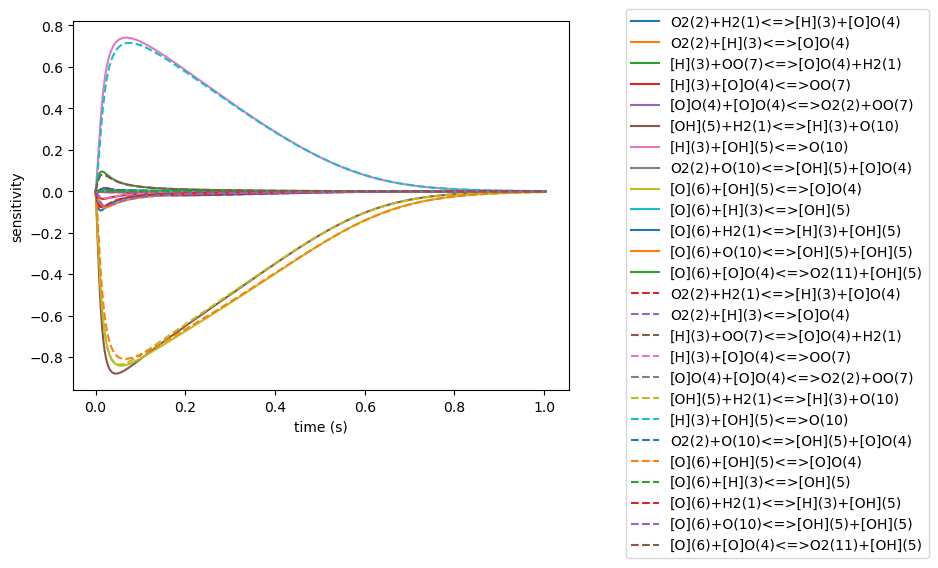

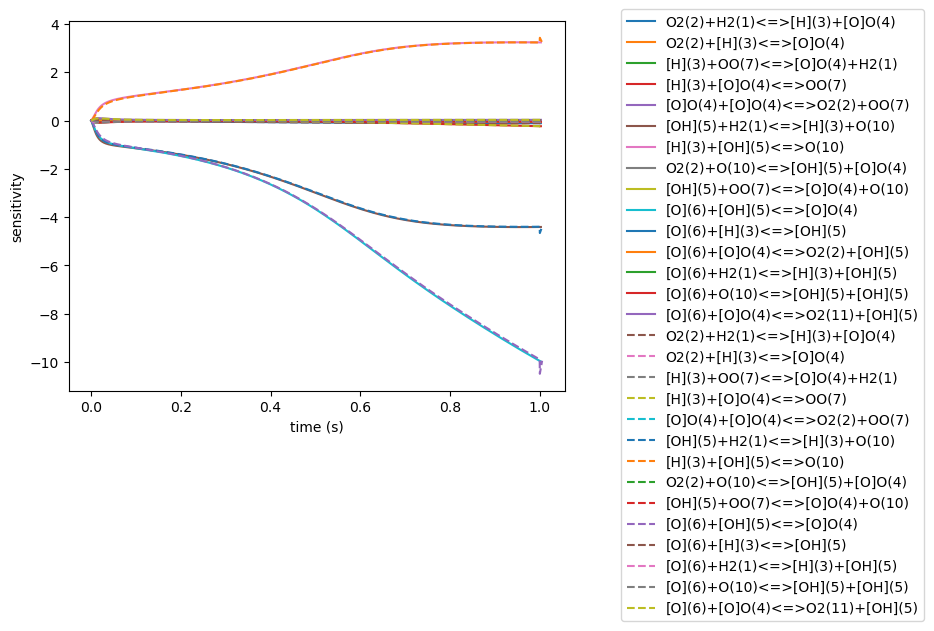

In [40]:
# plot the results of the sensitivity (for comparison against the non-cantera way of doing it)


reaction_system_index = 0
for sens_species in sensitive_species:
    csvfile_path1 = os.path.join(uncertainty.output_directory, 'solver',
                                'sensitivity_{0}_SPC_{1}.csv'.format(reaction_system_index+1,
                                                                     sens_species.index))
    time1, data_list1 = rmgpy.tools.plot.parse_csv_data(csvfile_path1)
    
    csvfile_path2 = os.path.join(uncertainty2.output_directory, 'solver',
                                'sensitivity_{0}_SPC_{1}.csv'.format(reaction_system_index+1,
                                                                     sens_species.index))
    time2, data_list2 = rmgpy.tools.plot.parse_csv_data(csvfile_path2)
    
    
    times1 = time1.data
    times2 = time2.data
    for data in data_list1:
        if 'dG' in data.label:
            continue
        plt.plot(times1, data.data, label=data.label.split()[-1])

    for data in data_list2:
        if 'dG' in data.label:
            continue
        plt.plot(times2, data.data, label=data.label.split()[-1], linestyle='dashed')

    plt.xlabel('time (s)')
    plt.ylabel('sensitivity')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [41]:
# try a surface mechanism

uncertainty3 = rmgpy.tools.uncertainty.Uncertainty(output_directory='test_sens_ct_surf')

sevy_mech = '/home/moon/nitridation/fe110_20241206/'
s_chemkin = os.path.join(sevy_mech, 'chem_annotated-gas.inp')
s_chemkin_surface = os.path.join(sevy_mech, 'chem_annotated-surface.inp')
s_dict = os.path.join(sevy_mech, 'species_dictionary.txt')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(s_chemkin, s_dict, surface_path=s_chemkin_surface)

uncertainty3.species_list = species_list
uncertainty3.reaction_list = reaction_list



In [42]:
uncertainty3.species_list[3]

In [48]:
# NH3 mech
initial_mole_fractions = {
    [x for x in uncertainty3.species_list if x.to_chemkin() == 'O2(3)'][0]: 0.5,  # O2
    [x for x in uncertainty3.species_list if x.to_chemkin() == 'NH3(2)'][0]: 0.5,  # NH3
}
initial_surface_coverages = {
    [x for x in uncertainty3.species_list if x.to_chemkin() == 'X(1)'][0]: 1.0,  # X
}

sensitive_species = [x for x in uncertainty3.species_list if x.to_chemkin() == 'X(1)'] + \
    [x for x in uncertainty3.species_list if x.to_chemkin() == 'HX(8)']

T = 700
P = 100000.0

termination_time = 1e-3

uncertainty3.sensitivity_analysis(
    initial_mole_fractions,
    sensitive_species,
    T,
    P,
    termination_time,
    use_cantera=True,
    sensitivity_threshold=1e-1,
    initial_surface_coverages=initial_surface_coverages
)

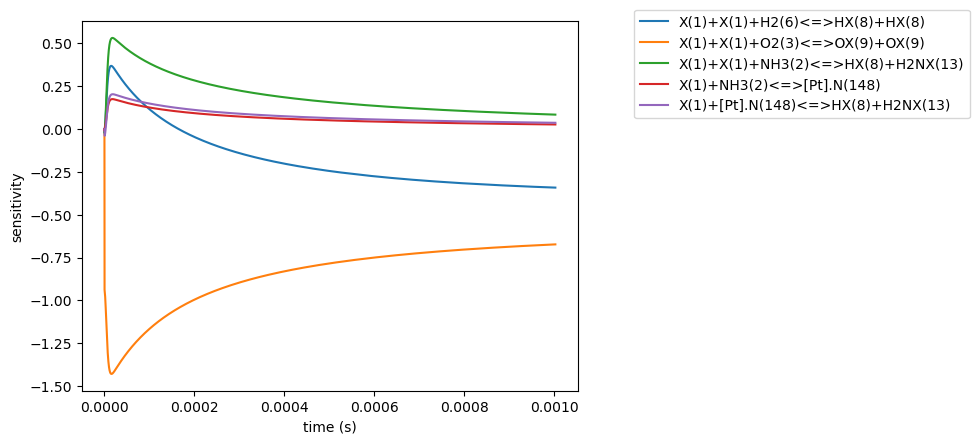

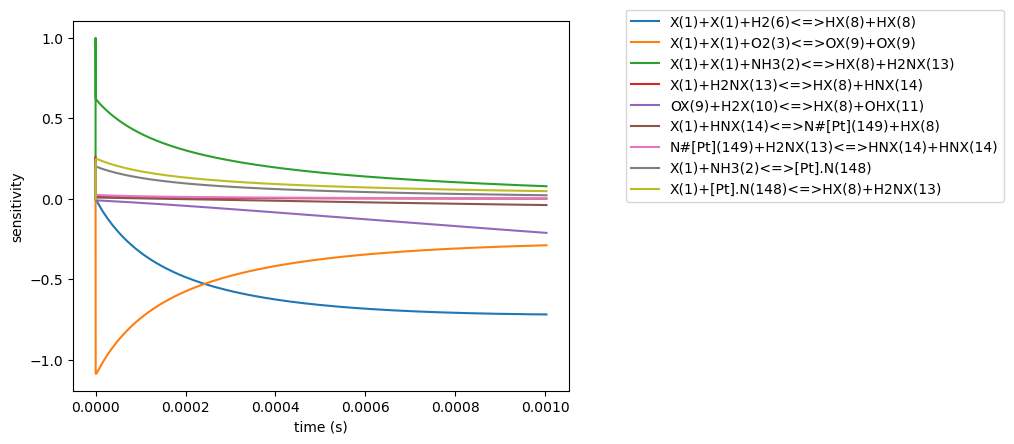

In [49]:
# plot the results of the sensitivity (for comparison against the non-cantera way of doing it)

reaction_system_index = 0
for sens_species in sensitive_species:
    csvfile_path3 = os.path.join(uncertainty3.output_directory, 'solver',
                                'sensitivity_{0}_SPC_{1}.csv'.format(reaction_system_index+1,
                                                                     sens_species.index))
    time3, data_list3 = rmgpy.tools.plot.parse_csv_data(csvfile_path3)

    times3 = time3.data
    for data in data_list3:
        if 'dG' in data.label:
            continue
        plt.plot(times3, data.data, label=data.label.split()[-1])

    plt.xlabel('time (s)')
    plt.ylabel('sensitivity')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()